In [1]:
## !jt -t chesterish  # set given theme
#!jt -r # reset default theme

# Southern Women Dataset
## An illustration of agglomerative clustering and polarisation evaluation in bipartite networks
### Adrián Fernández Cid

## Outline
### 1. Data and unipartite projection
### 2. Hierarchical/agglomerative clustering


## 1. Data and unipartite projection

The Southern Women dataset is a bipartite network of 18 women linked to 14 different social events only if they attended the given event. It is a popular dataset for testing clustering methods in bipartite networks, as there are two distinct communities of women, each preferring one of two classes of social event.

Data from http://casos.cs.cmu.edu/computational_tools/datasets/external/davis/index2.html.

Let us load and check the data;

In [1]:
import xml.etree.ElementTree as ET
tree = ET.parse('../data/SouthernWomen.xml')
root = tree.getroot()

In [2]:
#recursively check all (*) elements in tree and print 
#their tag and atribute
for element in root.iter('*'): 
    print(element.tag, element.attrib)

DynamicMetaNetwork {'id': 'davis'}
MetaNetwork {'id': 'davis'}
nodes {}
nodeclass {'type': 'Agent', 'id': 'agent'}
node {'id': 'EVELYN'}
node {'id': 'LAURA'}
node {'id': 'THERESA'}
node {'id': 'BRENDA'}
node {'id': 'CHARLOTTE'}
node {'id': 'FRANCES'}
node {'id': 'ELEANOR'}
node {'id': 'PEARL'}
node {'id': 'RUTH'}
node {'id': 'VERNE'}
node {'id': 'MYRNA'}
node {'id': 'KATHERINE'}
node {'id': 'SYLVIA'}
node {'id': 'NORA'}
node {'id': 'HELEN'}
node {'id': 'DOROTHY'}
node {'id': 'OLIVIA'}
node {'id': 'FLORA'}
nodeclass {'type': 'Event', 'id': 'event'}
node {'id': 'E1'}
node {'id': 'E2'}
node {'id': 'E3'}
node {'id': 'E4'}
node {'id': 'E5'}
node {'id': 'E6'}
node {'id': 'E7'}
node {'id': 'E8'}
node {'id': 'E9'}
node {'id': 'E10'}
node {'id': 'E11'}
node {'id': 'E12'}
node {'id': 'E13'}
node {'id': 'E14'}
networks {}
network {'sourceType': 'Agent', 'source': 'agent', 'targetType': 'Event', 'target': 'event', 'id': 'agent x event'}
link {'source': 'EVELYN', 'target': 'E1'}
link {'source': 'EV

Recover nodes (women and events):

In [3]:
nodes = []
for node in root.iter('node'): 
    nodes.append(node.attrib["id"])

In [4]:
print(nodes)
women = nodes[:18]
events = nodes[18:]

['EVELYN', 'LAURA', 'THERESA', 'BRENDA', 'CHARLOTTE', 'FRANCES', 'ELEANOR', 'PEARL', 'RUTH', 'VERNE', 'MYRNA', 'KATHERINE', 'SYLVIA', 'NORA', 'HELEN', 'DOROTHY', 'OLIVIA', 'FLORA', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14']


Define a dictionary containing all events each of the women attended:

In [5]:
woman2event = {w:[] for w in women}
for link in root.iter('link'): 
    source = link.attrib["source"]
    target = link.attrib["target"]
    woman2event[source].append(target)
woman2event

{'EVELYN': ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E8', 'E9'],
 'LAURA': ['E1', 'E2', 'E3', 'E5', 'E6', 'E7', 'E8'],
 'THERESA': ['E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9'],
 'BRENDA': ['E1', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8'],
 'CHARLOTTE': ['E3', 'E4', 'E5', 'E7'],
 'FRANCES': ['E3', 'E5', 'E6', 'E8'],
 'ELEANOR': ['E5', 'E6', 'E7', 'E8'],
 'PEARL': ['E6', 'E8', 'E9'],
 'RUTH': ['E5', 'E7', 'E8', 'E9'],
 'VERNE': ['E7', 'E8', 'E9', 'E12'],
 'MYRNA': ['E8', 'E9', 'E10', 'E12'],
 'KATHERINE': ['E8', 'E9', 'E10', 'E12', 'E13', 'E14'],
 'SYLVIA': ['E7', 'E8', 'E9', 'E10', 'E12', 'E13', 'E14'],
 'NORA': ['E6', 'E7', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14'],
 'HELEN': ['E7', 'E8', 'E10', 'E11', 'E12'],
 'DOROTHY': ['E8', 'E9'],
 'OLIVIA': ['E9', 'E11'],
 'FLORA': ['E9', 'E11']}

Define a dictionary containing a binary feature vector per woman, the vector corresponding to the attendance value (yes:1, no:0) of the woman to the corresponding event. Although we could also project the network on events rather than on women, from a conceptual (social) perspective it is more interesting to do it for women (even if the two communities are there in either case).

In [6]:
import numpy as np

n_events = len(events)
woman2vect = {w:[0]*n_events for w in women}
for w in women:
    for i, e in enumerate(events):
        if e in woman2event[w]:
            woman2vect[w][i] = 1
woman2vect

{'EVELYN': [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
 'LAURA': [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 'THERESA': [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
 'BRENDA': [1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 'CHARLOTTE': [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'FRANCES': [0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 'ELEANOR': [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 'PEARL': [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
 'RUTH': [0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
 'VERNE': [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0],
 'MYRNA': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0],
 'KATHERINE': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1],
 'SYLVIA': [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1],
 'NORA': [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
 'HELEN': [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0],
 'DOROTHY': [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 'OLIVIA': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
 'FLORA': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]}

Bipartite women-events network:

In [7]:
import networkx as nx

B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(events, bipartite=0)
B.add_nodes_from(women, bipartite=1)

#add edges
for link in root.iter('link'): 
    source = link.attrib["source"]
    target = link.attrib["target"]
    B.add_edge(source, target)

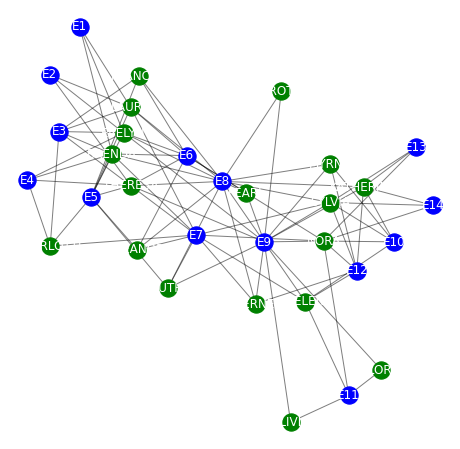

In [8]:
import matplotlib.pyplot as plt

pos = nx.fruchterman_reingold_layout(B);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(women, pos, node_size=300, node_color="green");
nx.draw_networkx_nodes(events, pos, node_size=300, node_color="blue");
nx.draw_networkx_edges(B, pos, alpha=0.500);
nx.draw_networkx_labels(B, pos, font_color="white");
plt.show()

Unipartite women network (projection of the above):

In [9]:
W = nx.Graph()
W.add_nodes_from(women)
n_women = len(women)

#add edges
for i, wi in enumerate(women):
    for e_idx in range(n_events):
        if woman2vect[wi][e_idx]==1:
            for j in range(i+1, n_women):
                if woman2vect[women[j]][e_idx]==1:
                    W.add_edge(wi, women[j])

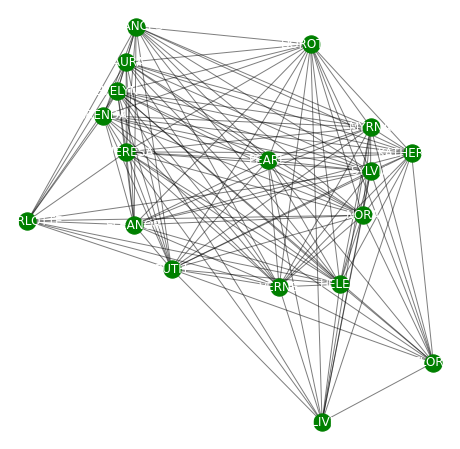

In [10]:
#pos = nx.fruchterman_reingold_layout(B);
plt.figure(figsize=(8,8));
plt.axis("off");
nx.draw_networkx_nodes(women, pos, node_size=300, node_color="green");
nx.draw_networkx_edges(W, pos, alpha=0.500);
nx.draw_networkx_labels(W, pos, font_color="white");
plt.show()

## 2. Hierarchical clustering

First, we define the distance matrix between nodes (events). To do so, we consider their pairwise phi-correlation (using the previously defined dictionary **woman2vect**), which we later turn into an Euclidean distance.

In [11]:
from sklearn.metrics import matthews_corrcoef

#build condensed distance matrix
phi = []
n_women = len(women)
for i, wi in enumerate(women):
    vec_wi = woman2vect[wi]
    for j in range(i+1, n_women):
        vec_wj = woman2vect[women[j]]  
        phi.append(matthews_corrcoef(vec_wi, vec_wj))
        #to check correlations are actually symmetric
        #print(matthews_corrcoef(vec_wi, vec_wj)
        #      , matthews_corrcoef(vec_wj,vec_wi))
        
#the expected length is n(n-1)/2
print(len(phi), n_women*(n_women-1)/2)
#turn correlations to Euclidean distances (the phi are somewhat like the cosine)
d = np.sqrt(2*(1-np.array(phi)))
d.shape

153 153.0


(153,)

We are now ready to apply hierarchical clustering. The scipy method gives:

(17, 4)


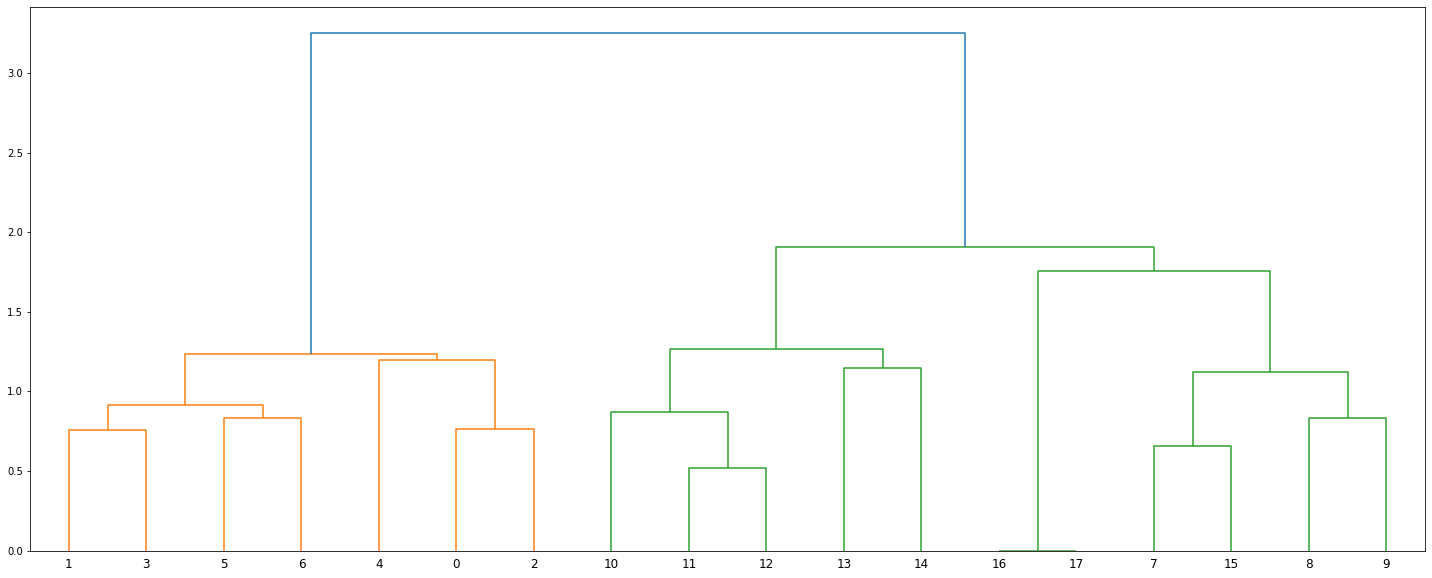

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage

z_sc = linkage(d, 'ward')
print(z_sc.shape)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z_sc)
plt.show()

In [13]:
z_sc

array([[16.        , 17.        ,  0.        ,  2.        ],
       [11.        , 12.        ,  0.51763809,  2.        ],
       [ 7.        , 15.        ,  0.66070272,  2.        ],
       [ 1.        ,  3.        ,  0.75592895,  2.        ],
       [ 0.        ,  2.        ,  0.76376262,  2.        ],
       [ 5.        ,  6.        ,  0.83666003,  2.        ],
       [ 8.        ,  9.        ,  0.83666003,  2.        ],
       [10.        , 19.        ,  0.87197892,  3.        ],
       [21.        , 23.        ,  0.91348978,  4.        ],
       [20.        , 24.        ,  1.12248408,  4.        ],
       [13.        , 14.        ,  1.14519414,  2.        ],
       [ 4.        , 22.        ,  1.19901425,  3.        ],
       [26.        , 29.        ,  1.23523106,  7.        ],
       [25.        , 28.        ,  1.26945367,  5.        ],
       [18.        , 27.        ,  1.75599648,  6.        ],
       [31.        , 32.        ,  1.9063863 , 11.        ],
       [30.        , 33.

While our method gives:

In [14]:
#for importing from parent directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

(17, 4)


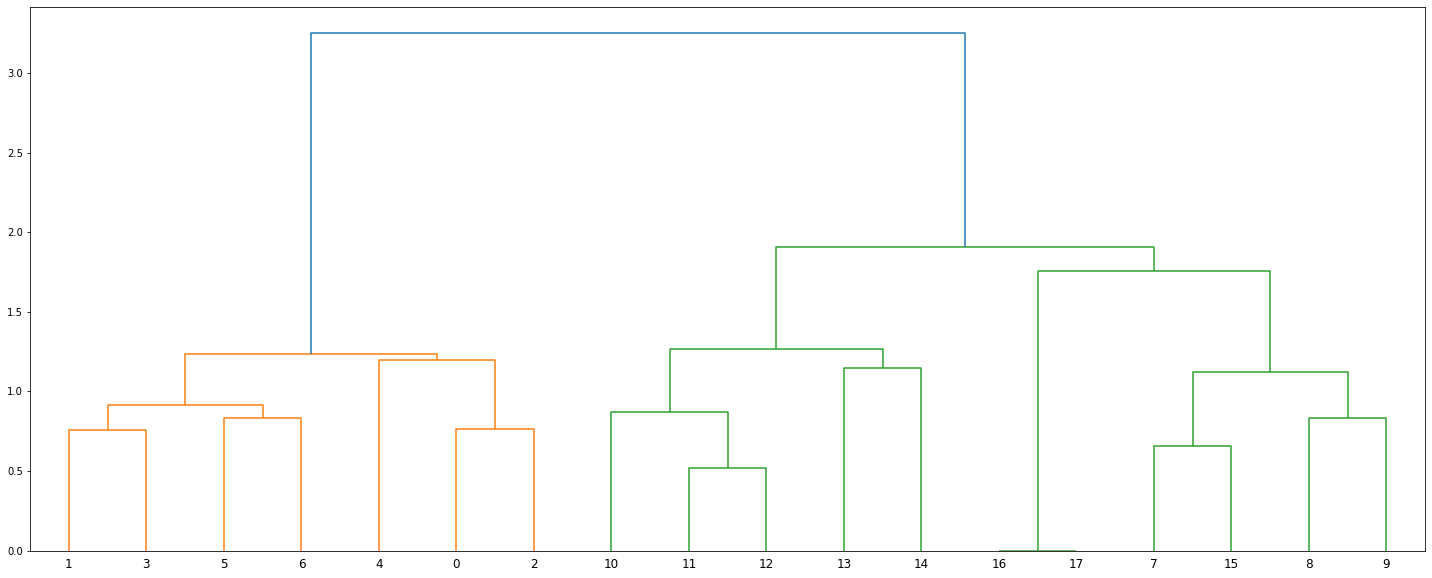

In [15]:
from scipy.cluster.hierarchy import dendrogram
from utils.clustering import agglomerative_clustering

z_ward, _ = agglomerative_clustering(d, method='ward')
print(z_ward.shape)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z_ward)
plt.show()

In [16]:
z_ward

array([[16.        , 17.        ,  0.        ,  2.        ],
       [11.        , 12.        ,  0.51763809,  2.        ],
       [ 7.        , 15.        ,  0.66070272,  2.        ],
       [ 1.        ,  3.        ,  0.75592895,  2.        ],
       [ 0.        ,  2.        ,  0.76376262,  2.        ],
       [ 5.        ,  6.        ,  0.83666003,  2.        ],
       [ 8.        ,  9.        ,  0.83666003,  2.        ],
       [10.        , 19.        ,  0.87197892,  3.        ],
       [21.        , 23.        ,  0.91348978,  4.        ],
       [20.        , 24.        ,  1.12248408,  4.        ],
       [13.        , 14.        ,  1.14519414,  2.        ],
       [ 4.        , 22.        ,  1.19901425,  3.        ],
       [26.        , 29.        ,  1.23523106,  7.        ],
       [25.        , 28.        ,  1.26945367,  5.        ],
       [18.        , 27.        ,  1.75599648,  6.        ],
       [31.        , 32.        ,  1.9063863 , 11.        ],
       [30.        , 33.

In [17]:
np.isclose(z_ward,z_sc)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

Great! Both methods show the expected division in two communities, and our adaptation of the scipy method is validated. The results are however not exactly the same as scipy's for methods that do not use the **nn_chain** algorithm (like "centroid"), but that is expected.

Let's now see what we get when using the polarisation distance, i.e.

$$d_{u,v} = d^c_{u,v}( \pi_u^{1+\alpha}\pi_v + \pi_v^{1+\alpha}\pi_u)$$

where $\alpha \in (0,1.6]$, $\pi_i$ is the size of cluster $i$ and $d^c_{u,v}$ is the centroid distance between $u$ and $v$, as the clustering criterion:

(17, 4)


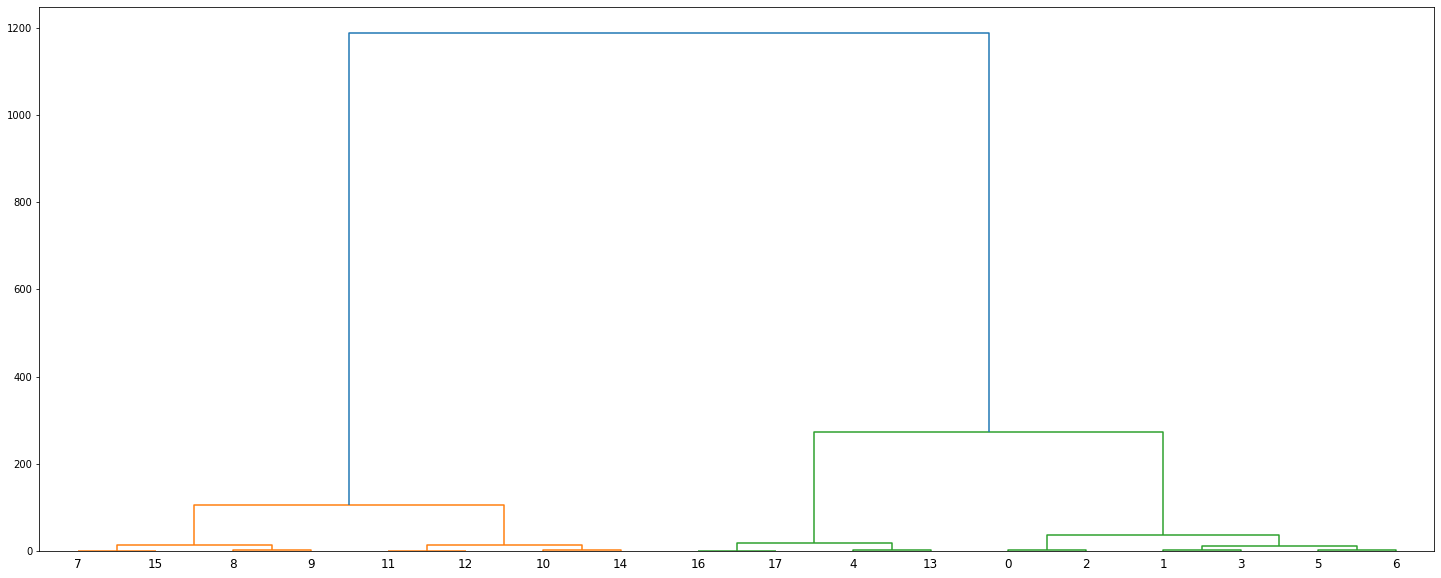

In [18]:
from scipy.cluster.hierarchy import dendrogram
from utils.clustering import agglomerative_clustering

z_pol, pol = agglomerative_clustering(d, method='polarisation', alpha=1, K=1)
print(z_pol.shape)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z_pol)
plt.show()

In [19]:
#have to change np print option by activating suppression;
#otherwise everything appears in lengthy scientific notation due to large distance (819)
np.set_printoptions(suppress=True)

z_pol, np.round(pol)

(array([[  16.        ,   17.        ,    0.        ,    2.        ],
        [  11.        ,   12.        ,    0.51763809,    2.        ],
        [   7.        ,   15.        ,    0.66070272,    2.        ],
        [   1.        ,    3.        ,    0.75592895,    2.        ],
        [   0.        ,    2.        ,    0.76376262,    2.        ],
        [   5.        ,    6.        ,    0.83666003,    2.        ],
        [   8.        ,    9.        ,    0.83666003,    2.        ],
        [  10.        ,   14.        ,    0.9812798 ,    2.        ],
        [   4.        ,   13.        ,    1.67975708,    2.        ],
        [  21.        ,   23.        ,   10.33495714,    4.        ],
        [  20.        ,   24.        ,   12.69945762,    4.        ],
        [  19.        ,   25.        ,   12.98075186,    4.        ],
        [  18.        ,   26.        ,   17.5216404 ,    4.        ],
        [  22.        ,   27.        ,   35.45941406,    6.        ],
        [  28.      

(17,)


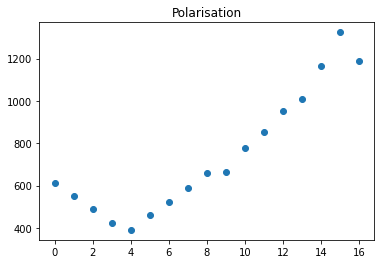

In [20]:
from matplotlib import pyplot as plt
print(pol.shape)
plt.plot(pol, "o")
plt.title("Polarisation")
plt.show()

Looks ok! Our method also computes the global polarisation $P$ (or $pol$ above) at every step (except when there is only one cluster, because the polarisation of such a system is null). The formula is:

$$P = K  \sum_{i=1}^{n}  \sum_{j=1}^{n}  d^c_{i,j} \pi_i^{1+\alpha}\pi_j $$

where $\alpha \in (0,1.6]$, $\pi_i$ is the size of cluster $i$ and $d^c_{i, j}$ is the centroid distance between $i$ and $j$.

Note that the last distance given in the linkage matrix, $1188$, is the actual polarisation of the system (up to the normalisation constant $K$, which we took as $1$ here anyway) when only two clusters (32 and 33) are left. 

Note also that, as we might expect, polarisation seems to increase more or less monotonically when clustering by polarisation distance. Remarkably though, the most polarised state is not the last one (with only 2 clusters) but the previous one (with 3): this makes sense when looking at the (polarisation) distance shown in the dendogram. When considering the network of events instead of that of women, the last state, with 2 clusters, was indeed the one with greater polarisation.

Since the computation of polarisation is obviously not available in the scipy function, we cannot compare them in this case.

Although the computation of the global polarisation is implemented for every method, for now only "polarisation" and "centroid" use the right distance for the above formula (the centroid distance): I still have to correct the distance for the other cases.

Clustering by centroid distance $d^c$ we get:

(17, 4)


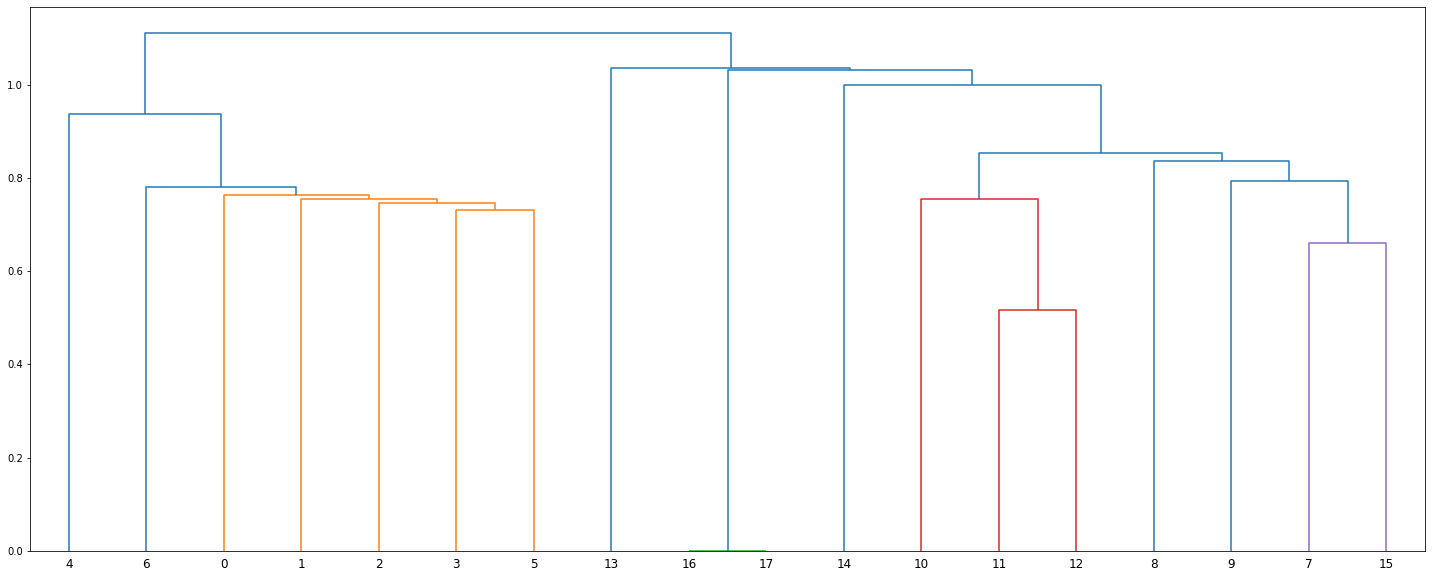

In [21]:
from scipy.cluster.hierarchy import dendrogram
from utils.clustering import agglomerative_clustering

z_ctr, pol = agglomerative_clustering(d, method='centroid', alpha=1, K=1)
print(z_ctr.shape)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(z_ctr)
plt.show()

In [22]:
#have to change np print option by activating suppression;
#otherwise everything appears in lengthy scientific notation due to large distance (819)
np.set_printoptions(suppress=True)

z_ctr, np.round(pol)

(array([[16.        , 17.        ,  0.        ,  2.        ],
        [11.        , 12.        ,  0.51763809,  2.        ],
        [ 7.        , 15.        ,  0.66070272,  2.        ],
        [ 3.        ,  5.        ,  0.73234174,  2.        ],
        [ 2.        , 21.        ,  0.74606232,  3.        ],
        [10.        , 19.        ,  0.7551559 ,  3.        ],
        [ 1.        , 22.        ,  0.75592895,  4.        ],
        [ 0.        , 24.        ,  0.76376262,  5.        ],
        [ 6.        , 25.        ,  0.78169659,  6.        ],
        [ 9.        , 20.        ,  0.7937161 ,  3.        ],
        [ 8.        , 27.        ,  0.83666003,  4.        ],
        [23.        , 28.        ,  0.85466316,  7.        ],
        [ 4.        , 26.        ,  0.93794948,  7.        ],
        [14.        , 29.        ,  0.99869509,  8.        ],
        [18.        , 31.        ,  1.03151247, 10.        ],
        [13.        , 32.        ,  1.036179  , 11.        ],
        

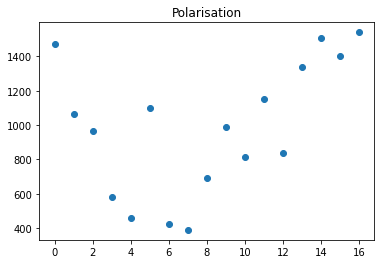

In [23]:
from matplotlib import pyplot as plt
#print(pol.shape)
plt.plot(pol, "o")
plt.title("Polarisation")
plt.show()

As expected, polarisation flutuates a bit more in this case. Remarkably, the maximum polarisation, which in this case is that of the last state, is higher with this method ($1540$) than with polarisation distance ($1324$). 

## 3. Dendogram/tree topologic distances for different alpha

Let's check the tree distance between our Ward, polarisation and centroid-obtained dendograms. I use the library *dendropy*.

In [24]:
#!pip install dendropy

Function to produce dendogram/tree string in Newick format from a linkage matrix:

In [26]:
import dendropy

def z_to_tree_str_newick(z):
    tree_str = ""
    clusters = women
    idx2woman = {i:wi for i, wi in enumerate(women)}
    woman2idx = {wi:i for i, wi in enumerate(women)}
    n = z.shape[0] + 1
    for i in range(n-1):
        #print(z[i, :2])
        new_clus = "(" + idx2woman[int(z[i,0])] + "," + idx2woman[int(z[i,1])] + ")"
        idx2woman[int(i+n)] = new_clus
        #print(int(i+z.shape[0]))
    idx2woman[int(i+n)] += ";"
    return idx2woman[int(2*n-2)]

tree_str1 = z_to_tree_str_newick(z_ctr)
tree_str2 = z_to_tree_str_newick(z_pol)

print(f"{tree_str1}\n{tree_str2}")

((CHARLOTTE,(ELEANOR,(EVELYN,(LAURA,(THERESA,(BRENDA,FRANCES)))))),(NORA,((OLIVIA,FLORA),(HELEN,((MYRNA,(KATHERINE,SYLVIA)),(RUTH,(VERNE,(PEARL,DOROTHY))))))));
((((PEARL,DOROTHY),(RUTH,VERNE)),((KATHERINE,SYLVIA),(MYRNA,HELEN))),(((OLIVIA,FLORA),(CHARLOTTE,NORA)),((EVELYN,THERESA),((LAURA,BRENDA),(FRANCES,ELEANOR)))));


Function to compute unweighted Robinson-Foulds distance between two trees given their strings in Newick format:

In [27]:
import dendropy
from dendropy.calculate import treecompare
def RF_dist(tree_str1, tree_str2):
    # trees need to have the same TaxonNamespace for RF distance
    tns = dendropy.TaxonNamespace()
    tree1 = dendropy.Tree.get_from_string(tree_str1, "newick",
            taxon_namespace=tns)
    tree2 = dendropy.Tree.get_from_string(tree_str2, "newick",
            taxon_namespace=tns)
    #have to compute bipàrtitions (whatever it means) of both trees 
    #before calling symmetric_difference
    tree1.encode_bipartitions()
    tree2.encode_bipartitions()
    #return unweighted RF distance
    return treecompare.symmetric_difference(tree1, tree2)

Produce and save plot of RF distances vs alpha:

In [29]:
from scipy.cluster.hierarchy import dendrogram
from utils.clustering import agglomerative_clustering

dist_p2c = []
dist_p2w = []
dist_p2p0 = []
#alphas = np.arange(0,50,1)
alphas = np.arange(0,40,1)

z_pol0, _ = agglomerative_clustering(d, method='polarisation'
                                          , alpha=0, K=1)
tp0_str = z_to_tree_str_newick(z_pol0)

for alpha in alphas:
    z_pol, _ = agglomerative_clustering(d, method='polarisation'
                                          , alpha=alpha, K=1)
    z_ctr, _ = agglomerative_clustering(d, method='centroid'
                                        ,alpha=1, K=1)#this alpha is for computing pol, not pol dist
    z_wrd, _ = agglomerative_clustering(d, method='ward')
    
    tp_str = z_to_tree_str_newick(z_pol)
    tc_str = z_to_tree_str_newick(z_ctr)
    tw_str = z_to_tree_str_newick(z_wrd)
    
    dist_p2c.append(RF_dist(tp_str, tc_str))
    dist_p2w.append(RF_dist(tp_str, tw_str))
    dist_p2p0.append(RF_dist(tp0_str, tp_str))

/home/bambusito/Desktop/backup/Dropbox/masterBCN/TFM/polarisation/utils/clustering.py:109: RuntimeWarning: overflow encountered in long_scalars
  p += ni**(1+alpha)*nj*D_centroids[condensed_index(n, i, j)]
/home/bambusito/Desktop/backup/Dropbox/masterBCN/TFM/polarisation/utils/clustering.py:280: RuntimeWarning: overflow encountered in long_scalars
  d_pol_xy_i = d_xy_i*(size_i*(size_x+size_y)**(1+alpha)+


In [30]:
#dist_p2p0, dist_p2c, dist_p2w

There are no topological changes in the dendogram produced with pol dist for the different alpha allowed: the distances between branches do change, but the structure is the same. 

Normalising $d^c$ does nothing coz its a proportionality constant in pol dist: the only thing that can make the allowed range of alpha relevant for the pol dist is a greater network size.

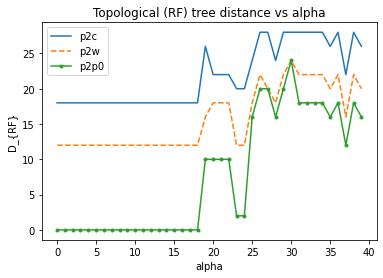

In [36]:
from matplotlib import pyplot as plt
"""plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})"""

plt.plot(alphas, dist_p2c, "-", label="p2c")
plt.plot(alphas, dist_p2w, "--", label="p2w")
plt.plot(alphas, dist_p2p0, ".-", label="p2p0")

plt.title("Topological (RF) tree distance vs alpha")
plt.xlabel("alpha")
plt.ylabel("D_{RF}")
plt.legend()
plt.savefig("../plots/rfdist_vs_alpha.png")
plt.show()